In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sdf
import glob
import tqdm
import os
import re
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
try:
    file_dir = os.path.dirname(os.path.realpath(__file__))
except NameError:
    file_dir = os.getcwd()
data_dir = "2run"
save_dir = "images"
DATA_DIR = os.path.join(file_dir, data_dir)
SAVE_DIR = os.path.join(file_dir, save_dir)
ALL_FILES = glob.glob(f"{DATA_DIR}/*sdf")
ALL_FILES.sort()
ALL_FILES = ALL_FILES[:-10]
POINTS = len(ALL_FILES)
EXTENT = [-10,10, -10, 10]
print(f"Found {POINTS} files")

Found 104 files


In [3]:
m = 9.10938356e-31
e = 1.60217662e-19
c = 299792458
PI = np.pi
epsilon = 8.85e-12
kb = 1.38064852e-23

In [11]:
with open (os.path.join(DATA_DIR, "input.deck"), "r") as myfile:
    data=myfile.read()

In [12]:
def find_value(info):
    regex = re.compile(rf"\s{info}\s*=\s*-?(\d+\.?\d*)")
    match = regex.search(data)
    if match:
        return float(match.group(1))
    else:
        return None

In [41]:
def find_angle(data):
    angle_reg = re.compile("upper_theta\s+=\s+(\d{0,3})\s{0,3}\*?\s{0,3}pi\s{0,3}\/\s{0,3}(\d{0,3})")
    a, b = angle_reg.search(data).groups()
    angle_pretty = f"{a}π/{b}"
    if not a:
        a = 1
    if not b:
        b = 1
    print(f"Angle: {angle_pretty}")
    angle_rad = int(a) * PI / int(b)
    angle_degree = angle_rad * 180 / PI
    angle_degree = round(angle_degree, 1)
    return angle_pretty, angle_degree, angle_rad

In [43]:
LAMBD= find_value("lambda0")*1e-6
LAS_TIME = int(find_value("las_time"))
T_MAX = int(find_value("simulation_end"))
DT = find_value("snapshot_freq")*1e-15
A0 = find_value("a0")
FACTOR = int(find_value("factor"))
NX = int(find_value("cells_x"))
NY = int(find_value("cells_y"))
X_MIN = -int(find_value("max_x"))
Y_MIN = -int(find_value("max_y"))
TEMPERATURE = find_value("temp")
angle_pretty, angle_degree, ANGLE = find_angle(data)
print("Values from input.deck:")
print("lambda0 = ", LAMBD)
print("laser_time = ", LAS_TIME)
print("t_end = ", T_MAX)
print("dt_snapshot = ", DT)
print("a0 = ", A0)
print("factor = ", FACTOR)
print("nx = ", NX)
print("ny = ", NY)
print("x_min = ", X_MIN)
print("y_min = ", Y_MIN)
print("temp = ", TEMPERATURE)
print("angle = ", angle_pretty)

Angle: π/6
Values from input.deck:
lambda0 =  1e-06
laser_time =  8
t_end =  20
dt_snapshot =  8e-17
a0 =  1.0
factor =  4
nx =  4000
ny =  4000
x_min =  -10
y_min =  -10
temp =  50.0
angle =  π/6


In [92]:
omega0 = 2*PI*c/LAMBD
tau = 2*PI/omega0
nc = epsilon*m*omega0**2/e**2
Er = m * omega0 * c / e
n0 = FACTOR*nc
LAS_TIME = LAS_TIME*tau
lambdaD = np.sqrt(epsilon * kb * TEMPERATURE / (n0 * e**2))
vth = np.sqrt(kb * TEMPERATURE / m)
f_max = 1/(2*DT)
omega_max = 2*PI*f_max
omega_max_natural = omega_max/omega0


print("Calculated Values for the simulation are:")
print(f"omega0 = {omega0:.4e}")
print(f"tau = {tau:.4e}")
print(f"nc = {nc:.4e}")
print(f"Er = {Er:.4e}")
print(f"n0 = {n0:.4e}")
print(f"lambdaD = {lambdaD:.4e}")
print(f"vth = {vth:.4e}")
print(f"f_max = {f_max:.4e}")
print(f"omega_max = {omega_max:.4e}")
print(f"omega_max_natural = {omega_max_natural:.4e}")

Calculated Values for the simulation are:
omega0 = 1.8837e+15
tau = 3.3356e-15
nc = 1.1143e+27
Er = 3.2107e+12
n0 = 4.4573e+27
lambdaD = 7.3072e-12
vth = 2.7528e+04
f_max = 6.2500e+15
omega_max = 3.9270e+16
omega_max_natural = 2.0848e+01


In [93]:
omega = np.linspace(-omega_max_natural, omega_max_natural, len(ALL_FILES))
X = np.linspace(X_MIN, -X_MIN, NX)
T = np.linspace(0, T_MAX, len(ALL_FILES))

In [94]:
def plot_field(data_dir, ax, component="y"):
    raw_data = sdf.read(data_dir)
    comp = {
        "x":raw_data.Electric_Field_Ex,
        "y":raw_data.Electric_Field_Ey,
        "z":raw_data.Electric_Field_Ez,
    }
    field = comp[component].data.T
    t = raw_data.Header['time']*1e15
    field = field/(field.max()+1e-10)
    ax.imshow(field**2, cmap='jet', origin='lower',
    extent=EXTENT,
    aspect='auto',
    )
    ax.set_xlabel('$x \, [\mu m]$')
    ax.set_ylabel('$y \, [\mu m]$')
    ax.set_title(f't = {t:.1f} fs')


def get_field(id, component):
    raw_data = sdf.read(ALL_FILES[id])
    comp = {
        "x":raw_data.Electric_Field_Ex,
        "y":raw_data.Electric_Field_Ey,
        "z":raw_data.Electric_Field_Ez,
    }
    field = comp[component].data.T
    return field

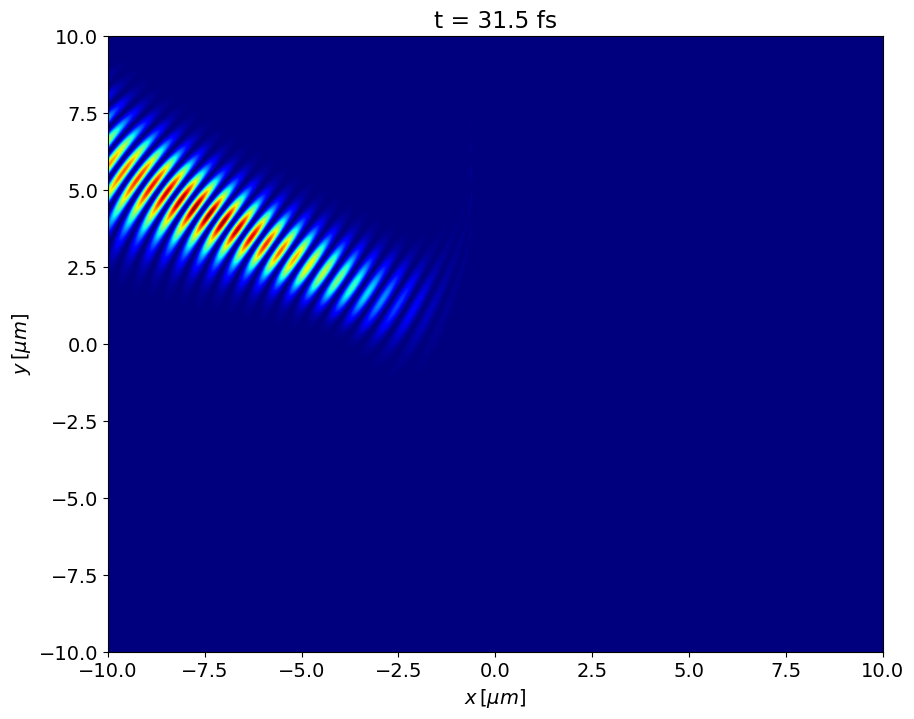

In [95]:
plot_field(ALL_FILES[-10], plt.gca(), component="y")

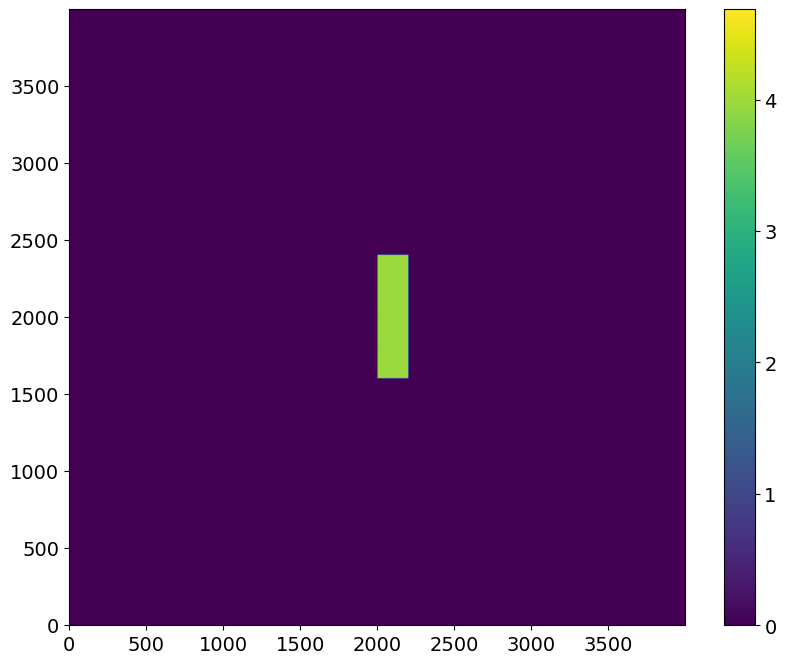

In [53]:
raw_data = sdf.read(ALL_FILES[0])
plt.imshow(raw_data.Derived_Number_Density_Electron.data.T/nc, origin="lower")
plt.colorbar()

In [61]:
raw_data = sdf.read(ALL_FILES[5])
Ex = raw_data.Derived_Number_Density_Electron.data.T/nc
point = (-2390, 2000)
Ex[point]

3.289815831450702

In [62]:
point1 = (1000, 1000)
point2 = (2050, 2000)
points3 = (1950, 2000)

Ex1 = np.zeros(POINTS)
Ex2 = np.zeros(POINTS)
Ex3 = np.zeros(POINTS)
Ey1 = np.zeros(POINTS)
Ey2 = np.zeros(POINTS)
Ey3 = np.zeros(POINTS)
Ez1 = np.zeros(POINTS)
Ez2 = np.zeros(POINTS)
Ez3 = np.zeros(POINTS)


for i in tqdm.tqdm(range(POINTS), desc="Calculating fields"):
    raw_data = sdf.read(ALL_FILES[i])
    Ex = raw_data.Electric_Field_Ex.data.T
    Ey = raw_data.Electric_Field_Ey.data.T
    Ez = raw_data.Electric_Field_Ez.data.T

    Ex1[i] = Ex[point1]
    Ex2[i] = Ex[point2]
    Ex3[i] = Ex[points3]

    Ey1[i] = Ey[point1]
    Ey2[i] = Ey[point2]
    Ey3[i] = Ey[points3]

    Ez1[i] = Ez[point1]
    Ez2[i] = Ez[point2]
    Ez3[i] = Ez[points3]
    

Calculating fields: 100%|██████████| 104/104 [00:45<00:00,  2.27it/s]


In [102]:
def get_image_name(name):
    if name is not None:
        fig_name = os.path.join(SAVE_DIR, name)
        if "." not in fig_name:
                    fig_name += ".png"
    else:
        fig_name = None
    return fig_name


In [111]:
def plot_fields(fields, component = "x", fig_name=None, show=True):
    if fields[0].max()>0:
        Es = fields
        plt.figure()
        titles = [f"$E_{component}$ at ({point1[0]}, {point1[1]})", f"$E_{component}$ at ({point2[0]}, {point2[1]})", f"$E_{component}$ at ({points3[0]}, {points3[1]})"]
        for i, E in enumerate(Es):
            plt.plot(T, E, label=titles[i])
        plt.legend()
        plt.xlabel(r"$t \;[\tau]$")
        plt.ylabel(f"$E_{component}$")
        fig_name = get_image_name(fig_name)
        if fig_name:
            plt.savefig(fig_name)
        if show:
            plt.show()
    else:
        print(f"E{component} is zero. Skipping plot.")

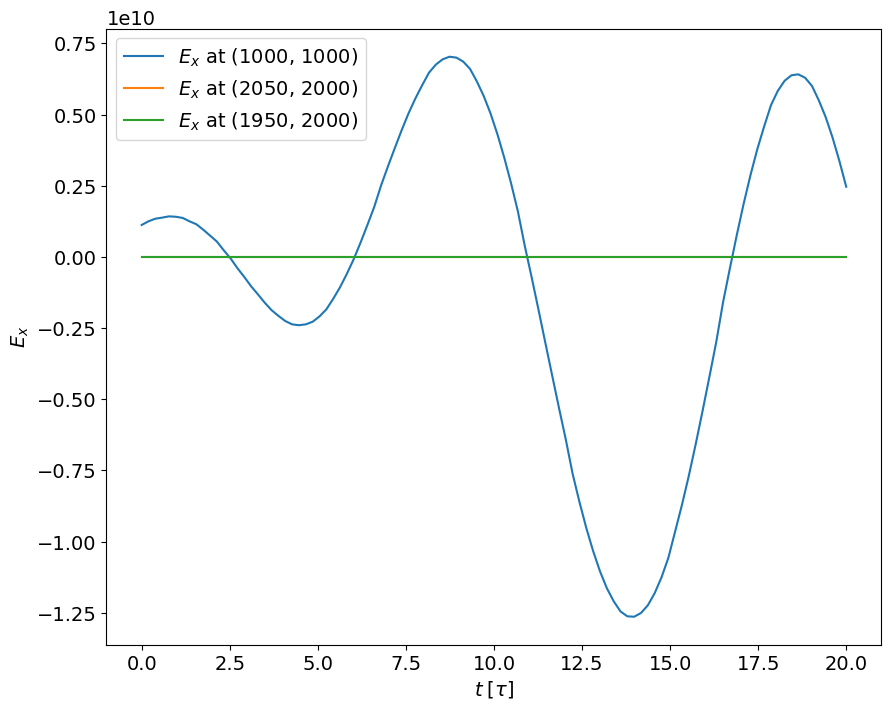

In [112]:
fields = [Ex1, Ex2, Ex3]
plot_fields(fields, component="x", fig_name="Ex")

In [119]:
def plot_one_fft(ax, E, component="y", title="", plot_lines=True, fig_name=None, show=True):
    fft = np.fft.fft(E)
    fft = np.fft.fftshift(fft)
    fft = np.abs(fft)
    fft = fft/(fft.max()+1e-10)
    ax.plot(omega, fft**2, label=f"$E_{component}$")
    ax.set_yscale("log")
    ax.set_xlim(0,)
    ax.set_xlabel("$\omega$")
    ax.set_ylabel("$\mathcal{|E|}^2$")
    ax.set_title(title, fontdict={"fontsize": 12})
    ax.legend()
    xticks = np.arange(1, int(omega_max_natural)+3, 2)
    ax.set_xticks(xticks)

    if plot_lines:
        for x in xticks:
            ax.axvline(x, color="k", alpha=0.7, linewidth=0.5)
    # fig_name = get_image_name(fig_name)
    # if fig_name:
    #     ax.savefig(fig_name)
    # if show:
    #     ax.show()

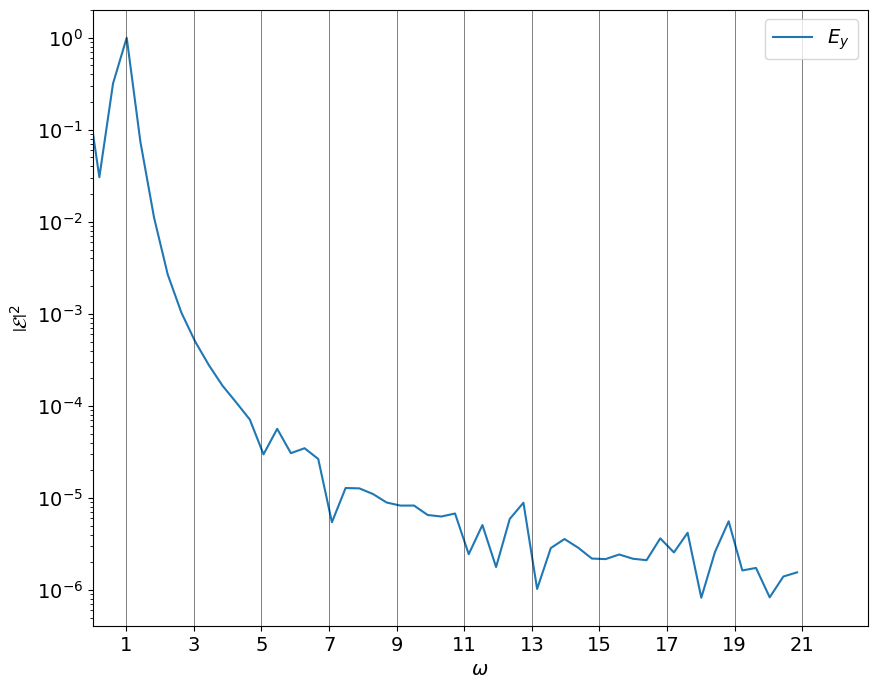

In [120]:
plot_one_fft(plt.gca(), Ex1, fig_name="fft_Ex1")

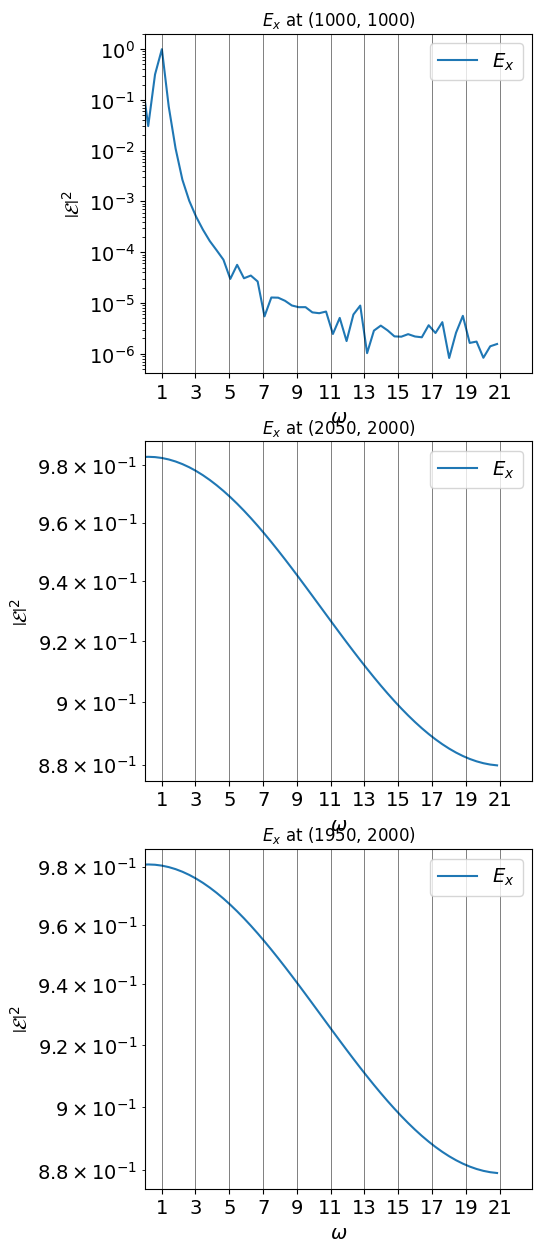

In [123]:
if Ex1.max()>0:
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    Es = [Ex1, Ex2, Ex3]
    # plot_fields(fields, component="x", fig_name="Ex")
    titles = [f"$E_x$ at ({point1[0]}, {point1[1]})", f"$E_x$ at ({point2[0]}, {point2[1]})", f"$E_x$ at ({points3[0]}, {points3[1]})"]
    for i, ax in enumerate(axes):
        plot_one_fft(ax,Es[i], component="x", title=titles[i])
else:
    print("Ex is zero. Skipping plot.")

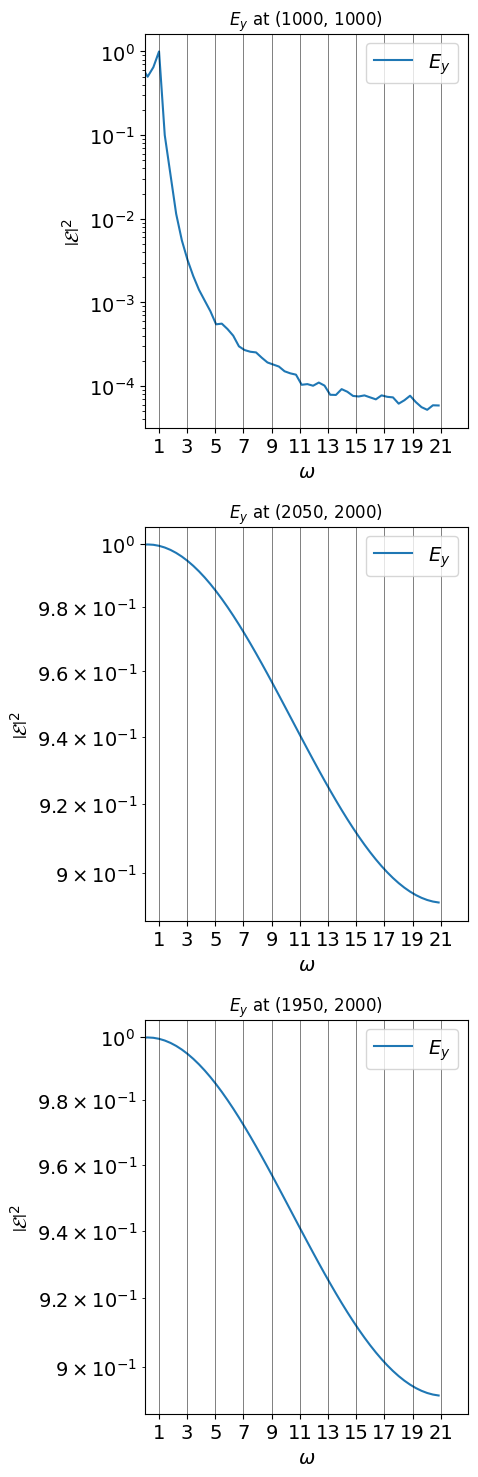

In [70]:
if Ey1.max()>0:
    fig, axes = plt.subplots(3, 1, figsize=(5, 15))
    Es = [Ey1, Ey2, Ey3]
    plot_fields(fields, component="y", fig_name="Ey")
    titles = [f"$E_y$ at ({point1[0]}, {point1[1]})", f"$E_y$ at ({point2[0]}, {point2[1]})", f"$E_y$ at ({points3[0]}, {points3[1]})"]
    for i, ax in enumerate(axes):
        plot_one_fft(ax,Es[i], component="y", title=titles[i])
    plt.tight_layout()
else:
    print("Ey is zero. Skipping plot.")

In [109]:
if Ez1.max()>0:
    fig, axes = plt.subplots(3, 1, figsize=(5, 20))
    Es = [Ez1, Ez2, Ez3]
    plot_fields(fields, component="z", fig_name="Ez")
    titles = [f"$E_z$ at ({point1[0]}, {point1[1]})", f"$E_z$ at ({point2[0]}, {point2[1]})", f"$E_z$ at ({points3[0]}, {points3[1]})"]
    for i, ax in enumerate(axes):
        plot_one_fft(ax,Es[i], component="z", title=titles[i])
    plt.tight_layout()
else:
    print("Ez is zero. Skipping plot.")

Ez is zero. Skipping plot.


In [124]:
def plot_ffts(save_fig=True, prefix="", show=True):
    if save_fig:
        fig_name_x = f"{prefix}_Ex_fft"
        fig_name_y = f"{prefix}_Ey_fft"
        fig_name_z = f"{prefix}_Ez_fft"
    else:
        fig_name_x = None
        fig_name_y = None
        fig_name_z = None

    if Ez1.max() > 0:
        fig, axes = plt.subplots(3, 1, figsize=(5, 15))
        Es = [Ez1, Ez2, Ez3]
        titles = [
            f"$E_z$ at ({point1[0]}, {point1[1]})",
            f"$E_z$ at ({point2[0]}, {point2[1]})",
            f"$E_z$ at ({points3[0]}, {points3[1]})",
        ]
        for i, ax in enumerate(axes):
            plot_one_fft(ax, Es[i], component="z", title=titles[i], show=show)
        fig_name = get_image_name(fig_name_z)
        if fig_name:
            fig.savefig(fig_name)
    else:
        print("Ez is zero. Skipping plot.")

    if Ex1.max() > 0:
        fig, axes = plt.subplots(3, 1, figsize=(5, 15))
        Es = [Ex1, Ex2, Ex3]
        titles = [
            f"$E_x$ at ({point1[0]}, {point1[1]})",
            f"$E_x$ at ({point2[0]}, {point2[1]})",
            f"$E_x$ at ({points3[0]}, {points3[1]})",
        ]
        for i, ax in enumerate(axes):
            plot_one_fft(ax, Es[i], component="x", title=titles[i], show=show)
        fig_name = get_image_name(fig_name_x)
        if fig_name:
            fig.savefig(fig_name)
    else:
        print("Ex is zero. Skipping plot.")

    if Ey1.max() > 0:
        fig, axes = plt.subplots(3, 1, figsize=(5, 15))
        Es = [Ey1, Ey2, Ey3]
        titles = [
            f"$E_y$ at ({point1[0]}, {point1[1]})",
            f"$E_y$ at ({point2[0]}, {point2[1]})",
            f"$E_y$ at ({points3[0]}, {points3[1]})",
        ]
        for i, ax in enumerate(axes):
            plot_one_fft(ax, Es[i], component="y", title=titles[i], show=show)
        fig_name = get_image_name(fig_name_y)
        if fig_name:
            fig.savefig(fig_name)
    else:
        print("Ey is zero. Skipping plot.")

Ez is zero. Skipping plot.


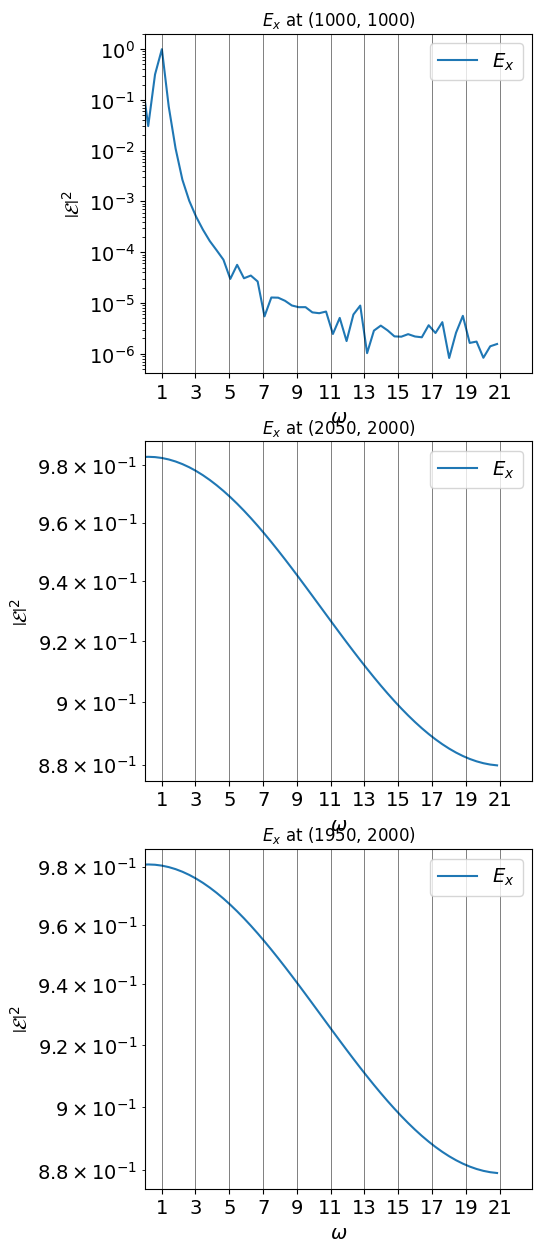

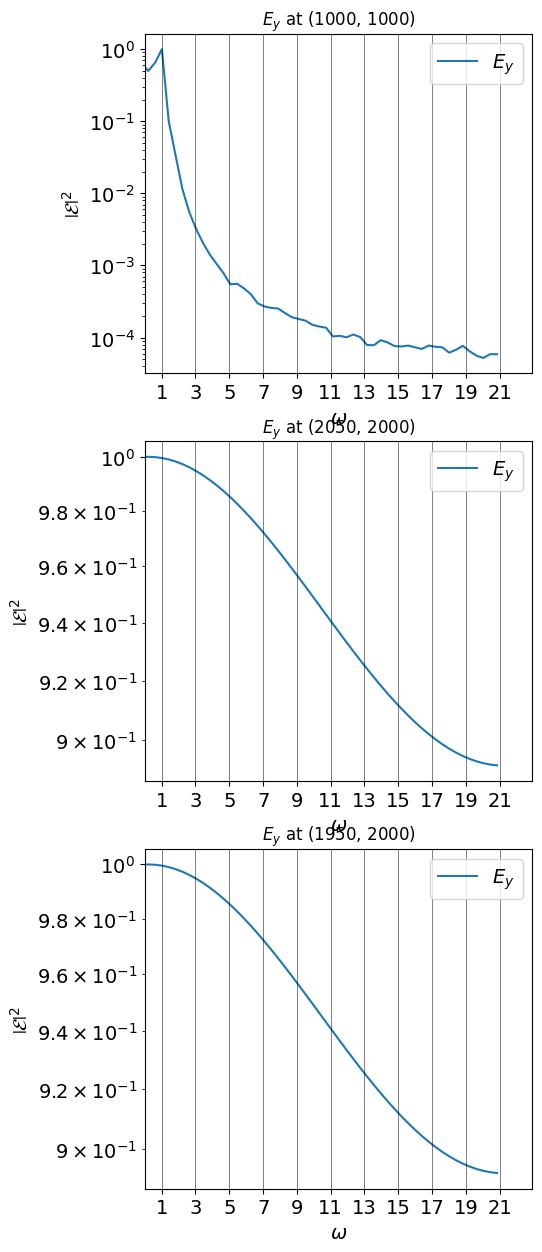

In [125]:
plot_ffts(save_fig=False, prefix="fft", show=False)